In [1]:
%reset
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functions import loader, splt, fitter, stats
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from uncertainties import *
from uncertainties import unumpy as unp

savedir = "D05/"

In [15]:
## Choose if is better with dedicated data...

all_data = loader.load_data( "../CloudVenetoAnalysisBis/20220*UngaussianityBySizeHighRes*/**/" )
data = all_data
len( data )

## Or with all data

# all_data = loader.load_data()
# data = loader.remove_duplicates( all_data,
#     lambda d: ( d['dep_polymers'], d['side'], d['defects_frac'], d['gamma'] ),
#     lambda d: d['runned_replicas']
# )
# data = data[ np.vectorize( lambda d: ( d['gamma'] == 0.4 ) and ( d['defects_frac'] == 0.2 ) )( data ) ]
# len( data )

assert( len( np.unique( [ d['gamma'] for d in data ] ) ) == 1 )
assert( len( np.unique( [ d['defects_frac'] for d in data ] ) ) == 1 )

# Resize to same size
min_size = 1000000
for d in data:
    min_size = np.min( [ min_size, len( d['chunks'] ) ] )
for d in data:
    d['chunks_crop'] = d['chunks'][:min_size]
print("Reduced to ",min_size)

Reduced to  4000


In [19]:
for d in data:
    # x, y = fitter.rebin_width( d['h_x'], d['h'], 0.0002 )
    # x, y = fitter.rebin_n( d['h_x'], d['h'], 50 )
    # d['fits'] = fitter.entropyc_fits( d['xs'], x )
    # d['skew'] = skew( d['chunks'], bias=True )
    # d['skew_u'] = stats.compute_in_decades( d['chunks'], lambda c: skew( c, bias=True ) )
    # d['G'] = stats.G( d['chunks'] )
    # d['G_u'] = stats.compute_in_decades( d['chunks'], lambda c: stats.G( c ) )
    # d['npskew'] = ( np.mean( d['chunks_crop'] ) - np.median( d['chunks_crop'] ) ) / np.std( d['chunks_crop'], ddof = 1 )

    d['npskew_u'] = stats.compute_in_decades( d['chunks'], lambda c: ( np.mean( c ) - np.median( c ) ) / np.std( c, ddof = 1 ), 'auto' )
    d['npskew_t'] = stats.compute_in_decades( d['chunks_crop'], lambda c: ( np.mean( c ) - np.median( c ) ) / np.std( c, ddof = 1 ), 'auto' )
    
    # d['Z&S'] = np.sqrt( 2 * len( d['chunks'] ) ) * ( np.mean( d['chunks'] ) - np.median( d['chunks'] ) ) / np.std( d['chunks'], ddof = 1 )
    # d['kurt'] = kurtosis( d['chunks'] )

len( data )

24

In [20]:
count = 0
for d in data:
    diff = d['npskew_u'] - d['npskew_t']
    if( np.abs( diff.n ) / diff.s > 2 ):
        count = count + 1
        print(f"{d['dep_polymers']} on 2^{np.log2(d['side'])} side lattice")
print(f"Incompatibili: {count}")

Trimers on 2^10.0 side lattice
Incompatibili: 1


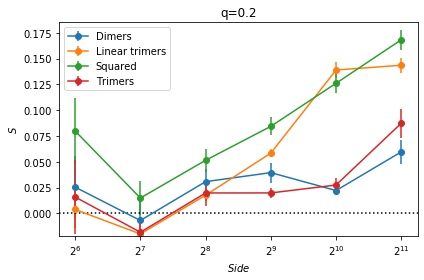

In [21]:
filtered_data = data
max = np.max( [ d['npskew_t'].n for d in filtered_data ] )
min = np.min( [ d['npskew_t'].n for d in filtered_data ] )

splt.oneitem_iterate_errorbar(
    len( filtered_data ),
    lambda d: filtered_data[d]['defects_frac'],
    lambda d: filtered_data[d]['dep_polymers'],
    lambda d: filtered_data[d]['side'],
    lambda d: [
        filtered_data[d]['npskew_t'],
    ],
    lambda it, l: [
        { 'label': fr"{l}", 'ls': '-', 'marker': 'o'  },
    ],
    lambda it: (
        plt.title( fr"q={it}" ),
        plt.ylim( np.min( [min * 1.1, min * 0.9] ), max * 1.1 ),
        plt.xscale( 'log', basex = 2 ),
        # plt.yscale( 'log', basey = 10 ),
        plt.xlabel( fr"$Side$" ),
        splt.hline( 0 ),
        plt.ylabel( fr"$S$" )
    )
)

plt.tight_layout()
plt.savefig( savedir + "nonparametric_skewness_ofL_witherrors.pdf" )
plt.savefig( savedir + "nonparametric_skewness_ofL_witherrors.png" )

KeyError: 'fits'

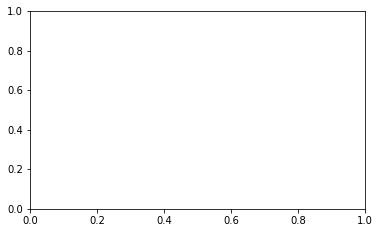

In [7]:
filtered_data = data[ np.vectorize( lambda d: ( d['dep_polymers'] == 'Squared' ) or ( d['dep_polymers'] == 'Linear trimers' ) )( data ) ]

def get_GG_peak( d ):
    mu = filtered_data[d]['fits']['GG']['pars'][0]
    s  = filtered_data[d]['fits']['GG']['pars'][1]
    xs = np.linspace( mu - 3 * s, mu + 3 * s, 10000 )
    ys = fitter.GG( xs, 1, *filtered_data[d]['fits']['GG']['pars'] )
    return xs[ np.argmax( ys ) ]

splt.oneitem_iterate(
    len( filtered_data ),
    lambda d: filtered_data[d]['dep_polymers'],
    lambda d: 1,
    lambda d: filtered_data[d]['side'],
    lambda d: [
        filtered_data[d]['fits']['GG']['pars'][0],
        get_GG_peak( d )
    ],
    lambda it, l: [
        { 'label': fr"Mean", 'ls': '-', 'marker': ''  },
        { 'label': fr"Peak", 'ls': '--', 'marker': '' }
    ],
    lambda it: (
        plt.title( f"{it}" ),
        plt.xscale( 'log', basex = 2 ),
        # plt.yscale( 'log', basey = 10 ),
        plt.xlabel( fr"Side" ),
        plt.ylabel( "$p_j$" )
    )
)

plt.tight_layout()
plt.savefig( savedir + "mean_and_peak_position_ofL_witherrors.pdf" )
plt.savefig( savedir + "mean_and_peak_position_ofL_witherrors.png" )

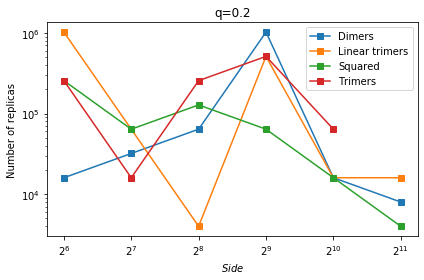

In [ ]:
filtered_data = data

splt.oneitem_iterate(
    len( filtered_data ),
    lambda d: filtered_data[d]['defects_frac'],
    lambda d: filtered_data[d]['dep_polymers'],
    lambda d: filtered_data[d]['side'],
    lambda d: [
        len( filtered_data[d]['chunks'] ),
    ],
    lambda it, l: [
        { 'label': fr"{l}", 'ls': '-', 'marker': 's'  }
    ],
    lambda it: (
        plt.title( fr"q={it}" ),
        plt.xscale( 'log', basex = 2 ),
        plt.yscale( 'log', basey = 10 ),
        plt.xlabel( fr"$Side$" ),
        splt.hline( 0 ),
        plt.ylabel( fr"Number of replicas" )
    )
)

plt.tight_layout()